In [1]:
import seisbench.data as sbd
import seisbench.generate as sbg

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader 

from snr.calc_snr import CalcSNR, SnrCalcStrategy

In [2]:
DATASETS_ORIGINS = ['ethz', 'geofon']
dataset_origin = 'ethz'
assert dataset_origin in DATASETS_ORIGINS, f'Expected dataset one of {DATASETS_ORIGINS}. Got {dataset_origin}.'

In [3]:
SBD_CLASSES={'ethz':sbd.ETHZ, 'geofon':sbd.GEOFON}
SBD_CLASS=SBD_CLASSES[dataset_origin]
SBD_CLASS

seisbench.data.ethz.ETHZ

In [4]:
NUM_SAMPLES=6000
PHASE_LABEL = 'P' # 'S'
SAMPLING_RATE = 100
SNR_THRESHOLD = 20
BATCH_SIZE=1000

In [5]:
SAVE_TO_PATH=f'/home/moshe/datasets/GFZ/noisy_datasets/{dataset_origin}_{NUM_SAMPLES}_sample_joachim_noises_energy_ratio_snr/'
TARGETS_PATH = f'/home/moshe/datasets/GFZ/targets/{dataset_origin}/'

In [7]:
assert os.path.exists(SAVE_TO_PATH), f'Path {SAVE_TO_PATH} does not exist'
assert os.path.exists(TARGETS_PATH), f'Path {TARGETS_PATH} does not exist'

## Download Data and Load to Memory

In [8]:
# Take only test data
data = SBD_CLASS(sampling_rate=SAMPLING_RATE, force=True).test()
print(data)

2023-01-10 18:41:13,660 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb


ETHZ - 10485 traces


In [9]:
targets_task23 = pd.read_csv(os.path.join(TARGETS_PATH,'task23.csv'))

In [10]:
merged_metadata = pd.merge(data.metadata, targets_task23, on='trace_name')

In [11]:
requested_event_list=[]

In [12]:
filtered_metadata = merged_metadata[(merged_metadata.phase_label == PHASE_LABEL) ]
if requested_event_list:
  filtered_metadata = filtered_metadata[filtered_metadata.source_id.isin(requested_event_list)]
else:
  print('All events will contribute to the resulting dataset')

gen  = sbg.SteeredGenerator(data, filtered_metadata )

All events will contribute to the resulting dataset


In [13]:
augmentations = [
            sbg.ChangeDtype(np.float32),
            sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
            sbg.SteeredWindow(windowlen=NUM_SAMPLES, strategy="pad")
        ]

gen.add_augmentations(augmentations)

@gen.augmentation
def get_arrival_sample(state_dict):
  _, metadata = state_dict["X"]
  key = f"trace_{state_dict['_control_']['full_phase_label']}_arrival_sample"
  state_dict['station_code'] = (metadata['station_code'], key)
  state_dict["onset_sample"] = (metadata[key], None)

num_dataset_traces = int(len(gen))

f'There are {num_dataset_traces} traces in the resulting dataset.'

'There are 9766 traces in the resulting dataset.'

In [14]:
loader = DataLoader(gen, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
len(loader)

10

In [15]:
def load_batch():
    print(f'Load {BATCH_SIZE} traces')
    dataset_dict = next(iter(loader))
    dataset=dataset_dict['X']
    print(f'{dataset.shape[0]} traces loaded.')
    print(f'Each trace has {dataset.shape[1]} channels.')
    print(f'Each channel has {dataset.shape[-1]} samples.')
    labels = dataset_dict['onset_sample']
    print(f'{labels.shape[0]} labels loaded. Each trace has a corresponding label')
    return dataset, labels

In [16]:
def calc_batch_snr(batch_traces, labels):
    batch_size = batch_traces.shape[0]
    assert batch_size == BATCH_SIZE
    assert batch_size == labels.shape[0]

    calc_snr = CalcSNR(SnrCalcStrategy.ENERGY_RATIO)
    # take the 0 channel for SNR calculations
    SNR_energy_ratio = torch.tensor([calc_snr(trace=batch_traces[i,0,:].numpy(), onset=int(labels[i]))
                             for i in range(batch_size)])

    print('SNR_energy_ratio shape', SNR_energy_ratio.shape)

    return SNR_energy_ratio

# fig, ax = plt.subplots(figsize=(15, 10))
# ax.scatter(range(num_dataset_traces), SNR_energy_ratio);

In [17]:
def get_high_snr_traces(traces, labels, SNR):
    high_SNR_traces_indices = np.argwhere(SNR >= SNR_THRESHOLD).squeeze()
    SNR_of_high_SNR_traces = SNR[high_SNR_traces_indices]
    high_SNR_traces = traces[high_SNR_traces_indices]
    high_SNR_traces_labels = labels[high_SNR_traces_indices]

    print(f'There are {traces.shape[0]} traces in the dataset')
    print(f'There are {len(high_SNR_traces_indices)} traces with SNRs higher than {SNR_THRESHOLD} dB')
    print(f'high_SNR_traces shape {high_SNR_traces.shape}')

    return high_SNR_traces, high_SNR_traces_labels, SNR_of_high_SNR_traces

In [18]:
for i in tqdm(range(len(loader))):
    traces, labels = load_batch()
    SNR = calc_batch_snr(batch_traces=traces, labels=labels)
    batch_high_SNR_traces, batch_high_SNR_traces_labels, batch_SNR_of_high_SNR_traces = get_high_snr_traces(traces=traces, labels=labels, SNR=SNR)
    (full_high_SNR_traces, full_high_SNR_traces_labels, full_SNR_of_high_SNR_traces) = (batch_high_SNR_traces.clone(), batch_high_SNR_traces_labels.clone(), batch_SNR_of_high_SNR_traces.clone()) if i == 0 else \
        (torch.vstack((full_high_SNR_traces,batch_high_SNR_traces)), torch.vstack((full_high_SNR_traces_labels.unsqueeze(dim=1), batch_high_SNR_traces_labels.unsqueeze(dim=1))).squeeze(), torch.vstack((full_SNR_of_high_SNR_traces.unsqueeze(dim=1), batch_SNR_of_high_SNR_traces.unsqueeze(dim=1))).squeeze())

full_SNR_of_high_SNR_traces.shape, full_high_SNR_traces.shape, full_high_SNR_traces_labels.shape

  0%|          | 0/10 [00:00<?, ?it/s]

Load 1000 traces


/home/moshe/GIT/summer_2022_Seismology/snr/calc_snr.py:46: RuntimeWarning: invalid value encountered in float_scalars
  return CalcSNR.to_db(float(Es / En))
 10%|█         | 1/10 [00:13<02:01, 13.47s/it]

1000 traces loaded.
Each trace has 3 channels.
Each channel has 6000 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 183 traces with SNRs higher than 20 dB
high_SNR_traces shape torch.Size([183, 3, 6000])
Load 1000 traces


 20%|██        | 2/10 [00:25<01:42, 12.86s/it]

1000 traces loaded.
Each trace has 3 channels.
Each channel has 6000 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 198 traces with SNRs higher than 20 dB
high_SNR_traces shape torch.Size([198, 3, 6000])
Load 1000 traces


 30%|███       | 3/10 [00:38<01:28, 12.57s/it]

1000 traces loaded.
Each trace has 3 channels.
Each channel has 6000 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 191 traces with SNRs higher than 20 dB
high_SNR_traces shape torch.Size([191, 3, 6000])
Load 1000 traces


 40%|████      | 4/10 [00:52<01:20, 13.36s/it]

1000 traces loaded.
Each trace has 3 channels.
Each channel has 6000 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 191 traces with SNRs higher than 20 dB
high_SNR_traces shape torch.Size([191, 3, 6000])
Load 1000 traces


 50%|█████     | 5/10 [01:07<01:08, 13.72s/it]

1000 traces loaded.
Each trace has 3 channels.
Each channel has 6000 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 172 traces with SNRs higher than 20 dB
high_SNR_traces shape torch.Size([172, 3, 6000])
Load 1000 traces


 60%|██████    | 6/10 [01:21<00:55, 13.80s/it]

1000 traces loaded.
Each trace has 3 channels.
Each channel has 6000 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 164 traces with SNRs higher than 20 dB
high_SNR_traces shape torch.Size([164, 3, 6000])
Load 1000 traces


 70%|███████   | 7/10 [01:32<00:39, 13.18s/it]

1000 traces loaded.
Each trace has 3 channels.
Each channel has 6000 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 196 traces with SNRs higher than 20 dB
high_SNR_traces shape torch.Size([196, 3, 6000])
Load 1000 traces


 80%|████████  | 8/10 [01:46<00:26, 13.30s/it]

1000 traces loaded.
Each trace has 3 channels.
Each channel has 6000 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 202 traces with SNRs higher than 20 dB
high_SNR_traces shape torch.Size([202, 3, 6000])
Load 1000 traces


 90%|█████████ | 9/10 [02:00<00:13, 13.42s/it]

1000 traces loaded.
Each trace has 3 channels.
Each channel has 6000 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 186 traces with SNRs higher than 20 dB
high_SNR_traces shape torch.Size([186, 3, 6000])
Load 1000 traces


100%|██████████| 10/10 [02:13<00:00, 13.37s/it]

1000 traces loaded.
Each trace has 3 channels.
Each channel has 6000 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 173 traces with SNRs higher than 20 dB
high_SNR_traces shape torch.Size([173, 3, 6000])


(torch.Size([1856]), torch.Size([1856, 3, 6000]), torch.Size([1856]))

In [19]:
torch.save(full_high_SNR_traces, os.path.join(SAVE_TO_PATH, 'original_dataset.pt'))
torch.save(full_high_SNR_traces_labels, os.path.join(SAVE_TO_PATH, 'original_labels.pt'))
torch.save(full_SNR_of_high_SNR_traces, os.path.join(SAVE_TO_PATH, 'original_traces_energy_ratio_snrs.pt'))

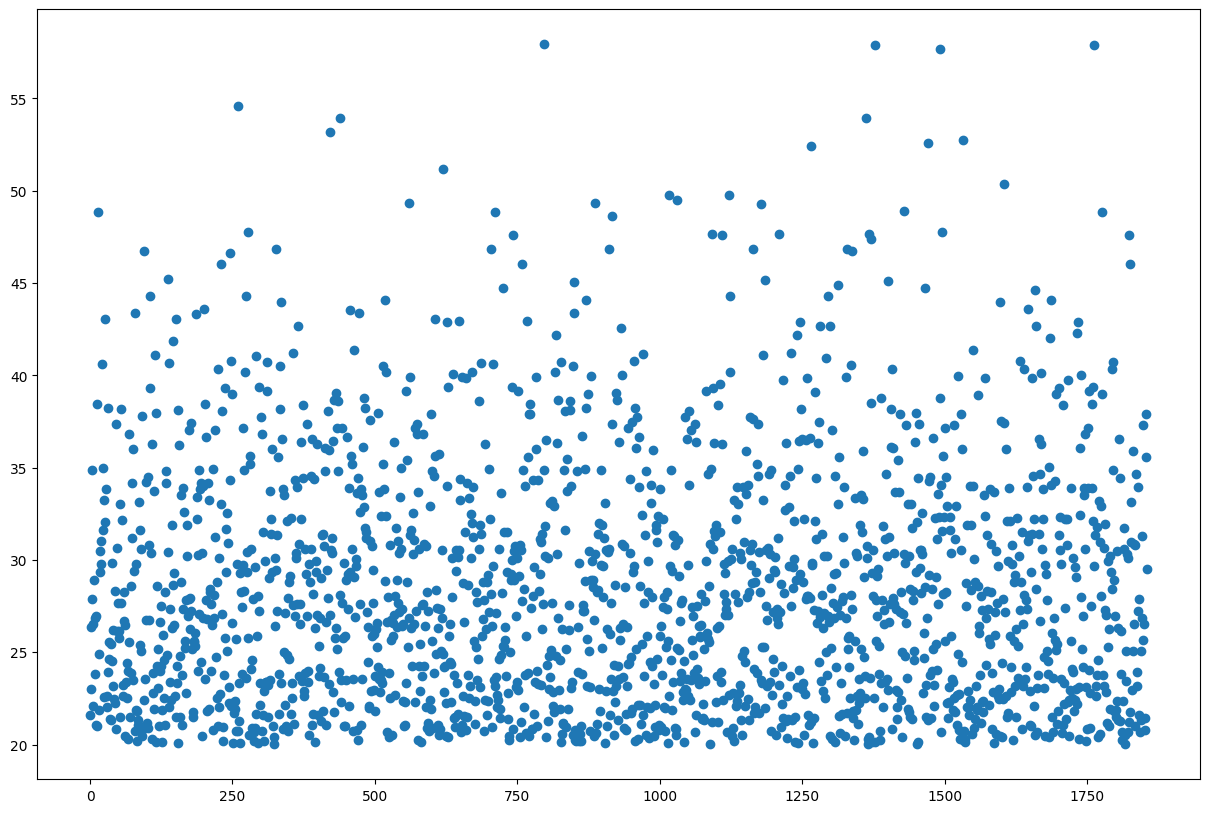

In [20]:
num_high_snr_traces = int(full_SNR_of_high_SNR_traces.shape[0])
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(range(num_high_snr_traces), full_SNR_of_high_SNR_traces);